In [1]:
import numpy as np
import time

import helper

In [2]:
source_path = "data/letters_source.txt"
target_path = "data/letters_target.txt"

source_sentences = helper.load_data(source_path)
target_sentences = helper.load_data(target_path)

In [3]:
source_sentences.split('\n')[:10]

['bsaqq',
 'npy',
 'lbwuj',
 'bqv',
 'kial',
 'tddam',
 'edxpjpg',
 'nspv',
 'huloz',
 'kmclq']

In [4]:
target_sentences.split('\n')[:10]

['abqqs',
 'npy',
 'bjluw',
 'bqv',
 'aikl',
 'addmt',
 'degjppx',
 'npsv',
 'hlouz',
 'cklmq']

In [5]:
def extract_character_vocab(data):
    special_words = ["<PAD>", "<UNK>", "<GO>", "<EOS>"]
    
    set_words = set([character for line in data.split("\n") for character in line])
    int_to_vocab = dict(enumerate(special_words+list(set_words)))
    vocab_to_int = {word:key for key,word in int_to_vocab.items()}
    
    return int_to_vocab, vocab_to_int

source_int_to_letter, source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter, target_letter_to_int = extract_character_vocab(target_sentences)

source_letter_ids = [[source_letter_to_int.get(character, source_letter_to_int["<UNK>"])\
                      for character in line]\
                     for line in source_sentences.split("\n")]
target_letter_ids = [[target_letter_to_int.get(character, target_letter_to_int["<UNK>"])\
                      for character in line]+[target_letter_to_int["<EOS>"]]\
                     for line in target_sentences.split("\n")]

In [6]:
print("source:")
print(source_letter_ids[:3])
print("targets")
print(target_letter_ids[:3])

source:
[[15, 7, 4, 26, 26], [12, 9, 14], [5, 15, 6, 18, 23]]
targets
[[4, 15, 26, 26, 7, 3], [12, 9, 14, 3], [15, 23, 5, 18, 6, 3]]


## Model

 **check tensorflow version**

In [7]:
from distutils.version import LooseVersion
import tensorflow as tf
from tensorflow.python.layers.core import Dense

assert LooseVersion(tf.__version__)>=LooseVersion("1.1"), 'Please use Tensorflow version 1.1 or newer'
print("Tensorflow version: {}".format(tf.__version__))

/Users/Young/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version: 1.12.0


## Hyperparameters

In [8]:
epochs = 60
batch_size = 128
rnn_size = 50
num_layers= 2
encoding_embedding_size = 15
decoding_embedding_size = 15
learning_rate = 0.001

## Inputs

In [9]:
def get_model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name="input")
    targets = tf.placeholder(tf.int32, [None, None], name="targets")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    ## What's this is all about?
    target_sequence_length = tf.placeholder(tf.int32, (None,), name="target_sequence_length")
    max_target_sequence_length = tf.reduce_max(target_sequence_length, name="max_target_len")
    source_sequence_length = tf.placeholder(tf.int32, (None,), name="source_sequence_length")
    
    return input_data, targets, lr, target_sequence_length,\
            max_target_sequence_length, source_sequence_length

## Sequence to Sequence model

### Encoder

The first bit of the model we'll build is the encoder. Here, we'll embed the input data, construct our encoder, then pass the embedded data to the encoder.

- Embed the input data using [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)
<img src="images/embed_sequence.png" />

- Pass the embedded input into a stack of RNNs.  Save the RNN state and ignore the output.
<img src="images/encoder.png" />

In [10]:
tf.contrib.layers.embed_sequence.__doc__

'Maps a sequence of symbols to a sequence of embeddings.\n\n  Typical use case would be reusing embeddings between an encoder and decoder.\n\n  Args:\n    ids: `[batch_size, doc_length]` `Tensor` of type `int32` or `int64`\n      with symbol ids.\n    vocab_size: Integer number of symbols in vocabulary.\n    embed_dim: Integer number of dimensions for embedding matrix.\n    unique: If `True`, will first compute the unique set of indices, and then\n         lookup each embedding once, repeating them in the output as needed.\n    initializer: An initializer for the embeddings, if `None` default for\n        current scope is used.\n    regularizer: Optional regularizer for the embeddings.\n    trainable: If `True` also add variables to the graph collection\n      `GraphKeys.TRAINABLE_VARIABLES` (see `tf.Variable`).\n    scope: Optional string specifying the variable scope for the op, required\n        if `reuse=True`.\n    reuse: If `True`, variables inside the op will be reused.\n\n  Ret

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
x = np.linspace(-1,1)
y = np.tanh(x)

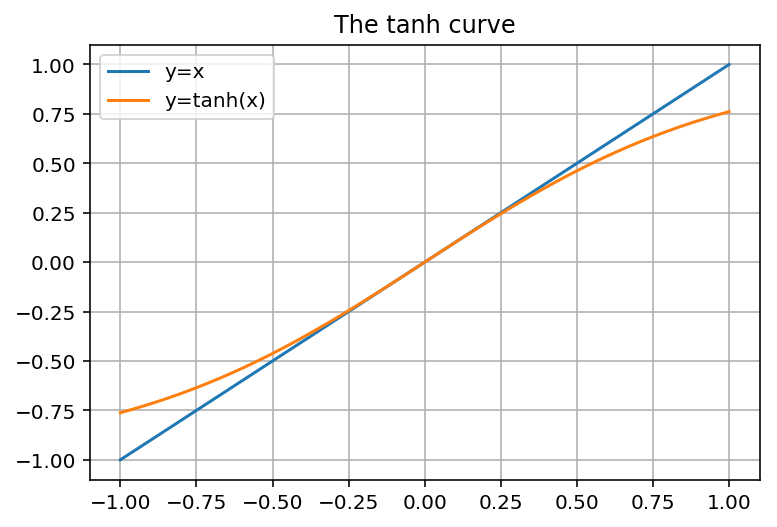

In [13]:
plt.plot(x, x)
plt.plot(x, y)
plt.legend(["y=x","y=tanh(x)"])
plt.title("The tanh curve")
plt.grid()

In [14]:
tf.contrib.layers.embed_sequence

<function tensorflow.contrib.layers.python.layers.encoders.embed_sequence(ids, vocab_size=None, embed_dim=None, unique=False, initializer=None, regularizer=None, trainable=True, scope=None, reuse=None)>

In [15]:
def encoding_layer(input_data, rnn_size, num_layers,
                  source_sequence_length, source_vocab_size,
                  encoding_embedding_size):
    
    #     embeddings shape -> [vocab_size, embed_dim]
    enc_embed_input = tf.contrib.layers.embed_sequence(ids=input_data,
                                                       vocab_size=source_vocab_size,
                                                       embed_dim=encoding_embedding_size)
    
    def make_cell(rnn_size):
        enc_cell = tf.contrib.rnn.LSTMCell(num_units=rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1,0.1, seed=2))
        return enc_cell
    
    enc_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    
    enc_output, enc_state = tf.nn.dynamic_rnn(cell=enc_cell,
                                              inputs=enc_embed_input, 
                                              sequence_length=source_sequence_length,
                                              dtype=tf.float32)
    return enc_output, enc_state

### Decoder

In [16]:
def process_decoder_input(target_data, vocab_to_int, batch_size):
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    decoder_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int["<GO>"]), ending], 1)
    
    return decoder_input

### Set up the decoder components

#### 4- Training decoder
Essentially, we'll be creating two decoders which share their parameters. One for training and one for inference. The two are similar in that both created using tf.contrib.seq2seq.**BasicDecoder** and tf.contrib.seq2seq.**dynamic_decode**. They differ, however, in that we feed the the target sequences as inputs to the training decoder at each time step to make it more robust.

We can think of the training decoder as looking like this (except that it works with sequences in batches):
<img src="images/sequence-to-sequence-training-decoder.png"/>
和给图片加描述,类似的结构.翻译也是可以用这样的结构.处理完输入的(encoder),然后再处理输出(decoder),
训练的时候,提供更多的信息,让模型更健壮

The training decoder **does not** feed the output of each time step to the next. Rather, the inputs to the decoder time steps are the target sequence from the training dataset (the orange letters).

#### 5- Inference decoder
The inference decoder is the one we'll use when we deploy our model to the wild.

<img src="images/sequence-to-sequence-inference-decoder.png"/>
预测的时候,decoder的上一个输出会作为下一个输入,如此循环

We'll hand our encoder hidden state to both the training and inference decoders and have it process its output. TensorFlow handles most of the logic for us. We just have to use the appropriate methods from tf.contrib.seq2seq and supply them with the appropriate inputs.

In [17]:
def decoding_layer(target_letter_to_int, decoding_embedding_size, num_layers, rnn_size,
                  target_sequence_length, max_target_sequence_length, enc_state, dec_input):
    # 1. Decoding embed
    target_vocab_size = len(target_letter_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    # 2. decoder cell
    def make_cell(rnn_size):
        dec_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return dec_cell
    
    dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    
    # 3. Dense layer,output the choice from the target vocabulary
    output_layer = Dense(target_vocab_size, 
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    # 4. 訓練用的decoder 和 預測用的 decoder
    # 訓練用的decoder
    with tf.variable_scope("decoder"):
        
        # 用於訓練時,讀取輸入
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                            sequence_length=target_sequence_length, 
                                                            time_major=False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                                           helper = training_helper, 
                                                           initial_state = enc_state,
                                                           output_layer = output_layer)
    
        training_decoder_output = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                                    impute_finished=True, 
                                                                    maximum_iterations=max_target_sequence_length)[0]
    # 預測用的decoder, 重用訓練的decoder,及其權重    
    with tf.variable_scope("decoder", reuse=True):
        # tile 複製變量
        start_tokens = tf.tile(tf.constant([target_letter_to_int["<GO>"]], dtype=tf.int32), 
                               [batch_size],
                               name="start_tokens")
        
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, 
                                                                    start_tokens=start_tokens,
                                                                    end_token=target_letter_to_int["<EOS>"])
        
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                                            helper=inference_helper,
                                                            initial_state=enc_state,
                                                            output_layer=output_layer)
        
        inference_decoder_output = tf.contrib.seq2seq.dynamic_decode(inference_decoder, 
                                                                     impute_finished=True,
                                                                     maximum_iterations=max_target_sequence_length)[0]
    # 預測的輸入 和 訓練的輸入 不同
    
    return training_decoder_output, inference_decoder_output

### 2.3 Seq2seq model

In [18]:
def seq2seq_model(input_data, targets, lr, batch_size, 
                  target_letter_to_int, target_sequence_length,
                  max_target_sequence_length, target_vocab_size, 
                  source_sequence_length, source_vocab_size, 
                  enc_embedding_size, dec_embedding_size, 
                  rnn_size, num_layers):
    
    _, enc_state = encoding_layer(input_data,
                                  rnn_size=rnn_size, 
                                  num_layers=num_layers,
                                  source_sequence_length=source_sequence_length,
                                  source_vocab_size=source_vocab_size,
                                  encoding_embedding_size=encoding_embedding_size)
    
    dec_input = process_decoder_input(target_data=targets, 
                                      vocab_to_int=target_letter_to_int,
                                      batch_size=batch_size)
    
    training_decoder_output, inference_decoder_output = decoding_layer(target_letter_to_int, 
                                                                       dec_embedding_size,
                                                                       num_layers,
                                                                       rnn_size,
                                                                       target_sequence_length, 
                                                                       max_target_sequence_length, 
                                                                       enc_state, 
                                                                       dec_input)
    return training_decoder_output, inference_decoder_output

*training_decoder_output_ , inference_decoder_output* 的輸出是這樣的
<img src="images/logits.png"/>

### Build train graph

In [19]:
train_graph = tf.Graph()

with train_graph.as_default():
    
    input_data, targets, lr, target_sequence_length,\
            max_target_sequence_length, source_sequence_length = get_model_inputs()
        
    training_decoder_output, inference_decoder_output = seq2seq_model(input_data, 
                                                                      targets,
                                                                      lr,
                                                                      batch_size,
                                                                      target_letter_to_int,
                                                                      target_sequence_length,
                                                                      max_target_sequence_length,
                                                                      len(target_letter_to_int),
                                                                      source_sequence_length,
                                                                      len(source_letter_to_int),
                                                                      encoding_embedding_size,
                                                                      decoding_embedding_size,
                                                                      rnn_size,
                                                                      num_layers)
    
    # rnn_output 输出全链接层的输出,用于训练
    training_logits = tf.identity(training_decoder_output.rnn_output, name="logits")
    # sample_id 输出结果中score最高的项目,用于预测
    inference_logits = tf.identity(inference_decoder_output.sample_id, name="predictions")
    
    # 计算loss,需要建一个固定大小的matrix, 而输入是长短不一的,需要使用mask处理用不到的数据
    masks = tf.sequence_mask(target_sequence_length, 
                             max_target_sequence_length,
                             dtype=tf.float32,
                             name="masks")
    
    with tf.name_scope("optimization"):
        
        cost = tf.contrib.seq2seq.sequence_loss(logits=training_logits, 
                                                targets=targets,
                                                weights=masks)
        
        optimizer = tf.train.AdamOptimizer(lr)
        
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) \
                           for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
        

In [20]:
def pad_sentence_batch(sentence_batch, pad_int):
    max_len = max([len(sentence) for sentence in sentence_batch])
    return [sentence+[pad_int]*(max_len-len(sentence)) for sentence in sentence_batch]

In [21]:
def get_batches(targets, sources, batch_size, source_pad_int, target_pad_int):
    
    for batch_i in range(len(sources)//batch_size):
        
        start_i = batch_i*batch_size
        target_sentence_batch = targets[start_i: start_i+batch_size]
        source_sentence_batch = sources[start_i: start_i+batch_size]
        
        target_sentence_pad = pad_sentence_batch(target_sentence_batch, target_pad_int)
        source_sentence_pad = pad_sentence_batch(source_sentence_batch, source_pad_int)
        
        target_sentence_lens = [len(target_sentence_pad[0])]*len(target_sentence_pad)
        source_sentence_lens = [len(source_sentence_pad[0])]*len(source_sentence_pad)
        
        yield target_sentence_pad, source_sentence_pad, target_sentence_lens, source_sentence_lens

### Now is time for training

In [22]:
# 把數據分成訓練集和驗證集
train_source = source_letter_ids[batch_size:]
train_target = target_letter_ids[batch_size:]
valid_source = source_letter_ids[:batch_size]
valid_target = target_letter_ids[:batch_size]

(valid_targets_batch, valid_sources_batch,\
 valid_targets_lengths, valid_source_lengths)= next(get_batches(valid_target, \
                                                                valid_source, batch_size, \
                                                                source_letter_to_int["<PAD>"],\
                                                                target_letter_to_int["<PAD>"]))
display = 20

checkpoint = "./checkpoint/practice_model"
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(1, epochs+1):
        for batch_i, (targets_batch, sources_batch,\
             targets_lengths, source_lengths) in \
        enumerate(get_batches(train_target, \
                              train_source, batch_size, \
                              source_letter_to_int["<PAD>"],\
                              target_letter_to_int["<PAD>"])):
            
            _, loss = sess.run([train_op, cost],
                              {input_data: sources_batch,
                               targets: targets_batch,
                               lr: learning_rate,
                               target_sequence_length: targets_lengths,
                               source_sequence_length: source_lengths})
            
            if batch_i % display == 0 and batch_i > 0:
                
                validation_loss = sess.run(cost,
                                          {input_data: valid_sources_batch,
                                           targets: valid_targets_batch,
                                           lr: learning_rate,
                                           target_sequence_length: valid_targets_lengths,
                                           source_sequence_length: valid_source_lengths
                                           })
                print("epoch {:>3}/{} Batch {:>4}/{} - Loss:{:>6.3f} - Validation loss: {:>6.3f}"
                     .format(epoch_i,
                             epochs,
                             batch_i,
                             len(train_source)//batch_size,
                             loss,
                             validation_loss))
            
        
    
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    print("Model trained and saved")

epoch   1/60 Batch   20/77 - Loss: 2.400 - Validation loss:  2.413
epoch   1/60 Batch   40/77 - Loss: 2.264 - Validation loss:  2.223
epoch   1/60 Batch   60/77 - Loss: 1.962 - Validation loss:  2.014
epoch   2/60 Batch   20/77 - Loss: 1.656 - Validation loss:  1.736
epoch   2/60 Batch   40/77 - Loss: 1.675 - Validation loss:  1.629
epoch   2/60 Batch   60/77 - Loss: 1.504 - Validation loss:  1.534
epoch   3/60 Batch   20/77 - Loss: 1.364 - Validation loss:  1.431
epoch   3/60 Batch   40/77 - Loss: 1.437 - Validation loss:  1.404
epoch   3/60 Batch   60/77 - Loss: 1.311 - Validation loss:  1.349
epoch   4/60 Batch   20/77 - Loss: 1.185 - Validation loss:  1.248
epoch   4/60 Batch   40/77 - Loss: 1.250 - Validation loss:  1.218
epoch   4/60 Batch   60/77 - Loss: 1.147 - Validation loss:  1.186
epoch   5/60 Batch   20/77 - Loss: 1.095 - Validation loss:  1.145
epoch   5/60 Batch   40/77 - Loss: 1.154 - Validation loss:  1.126
epoch   5/60 Batch   60/77 - Loss: 1.043 - Validation loss:  1

epoch  42/60 Batch   20/77 - Loss: 0.024 - Validation loss:  0.048
epoch  42/60 Batch   40/77 - Loss: 0.030 - Validation loss:  0.052
epoch  42/60 Batch   60/77 - Loss: 0.028 - Validation loss:  0.052
epoch  43/60 Batch   20/77 - Loss: 0.022 - Validation loss:  0.044
epoch  43/60 Batch   40/77 - Loss: 0.027 - Validation loss:  0.049
epoch  43/60 Batch   60/77 - Loss: 0.026 - Validation loss:  0.050
epoch  44/60 Batch   20/77 - Loss: 0.021 - Validation loss:  0.042
epoch  44/60 Batch   40/77 - Loss: 0.025 - Validation loss:  0.050
epoch  44/60 Batch   60/77 - Loss: 0.025 - Validation loss:  0.046
epoch  45/60 Batch   20/77 - Loss: 0.019 - Validation loss:  0.040
epoch  45/60 Batch   40/77 - Loss: 0.024 - Validation loss:  0.039
epoch  45/60 Batch   60/77 - Loss: 0.024 - Validation loss:  0.044
epoch  46/60 Batch   20/77 - Loss: 0.018 - Validation loss:  0.040
epoch  46/60 Batch   40/77 - Loss: 0.023 - Validation loss:  0.043
epoch  46/60 Batch   60/77 - Loss: 0.024 - Validation loss:  0

### 验证训练一下效果

In [38]:
def source_to_seq(text):
    sequence_len = 7
    return [source_letter_to_int.get(charater,source_letter_to_int["<UNK>"]) for charater in text] \
+ [source_letter_to_int["<PAD>"]]*(sequence_len-len(text))

In [51]:
input_sentence = "hana"
text = source_to_seq(input_sentence)

checkpoint = "./checkpoint/practice_model"

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    
    # 加载原先存放在graph里的 变量,还有运算
    loader = tf.train.import_meta_graph(checkpoint+".meta")
    loader.restore(sess, checkpoint)
    
    
    input_data = loaded_graph.get_tensor_by_name("input:0")
    logits = loaded_graph.get_tensor_by_name("predictions:0")
    source_sequence_length = loaded_graph.get_tensor_by_name("source_sequence_length:0")
    target_sequence_length = loaded_graph.get_tensor_by_name("target_sequence_length:0")
    
    answer_logits = sess.run(logits, {input_data: [text]*batch_size,
                                      target_sequence_length: [len(text)]*batch_size,
                                      source_sequence_length: [len(text)]*batch_size})[0]

pad = source_letter_to_int["<PAD>"]

print("Original Text:", input_sentence)

print("\nSource")
print(" Word Ids:  {}".format([i for i in text]))
print(" Input words: {}".format(" ".join([source_int_to_letter[i] for i in text])))
                                          
print("\n Target")
print("  Words Ids:    {}".format([np.argmax(i) for i in answer_logits]))
print("  Response Words: {}".format(" ".join([target_int_to_letter[np.argmax(i)] for i in answer_logits])))

    

INFO:tensorflow:Restoring parameters from ./checkpoint/practice_model
Original Text: hana

Source
 Word Ids:  [21, 4, 12, 4, 0, 0, 0]
 Input words: h a n a <PAD> <PAD> <PAD>

 Target
  Words Ids:    [4, 4, 21, 12, 3]
  Response Words: a a h n <EOS>
